In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Image directories
nickels_cropped_dir = "./nickels_cropped/"
nickels_cropped_files = glob(f"{nickels_cropped_dir}/*")

quarters_cropped_dir = "./quarters_cropped/"
quarters_cropped_files = glob(f"{quarters_cropped_dir}/*")

cents_cropped_dir = "./cents_cropped/"
cents_cropped_files = glob(f"{cents_cropped_dir}/*")

In [3]:
def calculate_moments(image):
    mean = np.mean(image)
    std_dev = np.std(image)
    
    if std_dev == 0:
        skewness = 0
        kurtosis = 0
    else:
        skewness = np.mean((image - mean) ** 3) / (std_dev ** 3)
        kurtosis = np.mean((image - mean) ** 4) / (std_dev ** 4) - 3
    
    return mean, std_dev, skewness, kurtosis

def extract_color_features(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract moments for each HSV component
    h_mean, h_std, h_skewness, h_kurtosis = calculate_moments(hsv_image[:,:,0])
    s_mean, s_std, s_skewness, s_kurtosis = calculate_moments(hsv_image[:,:,1])
    v_mean, v_std, v_skewness, v_kurtosis = calculate_moments(hsv_image[:,:,2])

    return [h_mean, h_std, h_skewness, h_kurtosis,
            s_mean, s_std, s_skewness, s_kurtosis,
            v_mean, v_std, v_skewness, v_kurtosis]

In [4]:
def create_ring_masks_const(image, num_rings):
    p = num_rings
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    masks = []

    for i in range(num_rings):
        area_ratio = (i + 1) / num_rings
        radius_outer = int(np.sqrt(area_ratio) * min(height/p, width/p))

        if i == 0:
            radius_inner = 0
        else:
            area_ratio_prev = i / num_rings
            radius_inner = int(np.sqrt(area_ratio_prev) * min(height/(p+1), width/(p+1)))

        mask = np.zeros_like(image, dtype = np.uint8)
        cv2.circle(mask, center, radius_outer, (255, 255, 255), thickness = -1)
        cv2.circle(mask, center, radius_inner, (0, 0, 0), thickness = -1)

        masks.append(mask)
        p -= 1

    return masks

def create_ring_masks_with_growth_factor(image, num_rings, growth_rate = 0.8, inner_outer_ratio = 0.5):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    masks = []

    for i in range(num_rings):
        adjusted_growth_rate = growth_rate ** i
        radius_ratio = inner_outer_ratio + (1 - inner_outer_ratio) * (i / num_rings)
        radius_outer = int(adjusted_growth_rate * radius_ratio * min(height, width))

        radius_inner = int(radius_outer * inner_outer_ratio)

        mask = np.zeros_like(image, dtype = np.uint8)
        cv2.circle(mask, center, radius_outer, (255, 255, 255), thickness = -1)
        cv2.circle(mask, center, radius_inner, (0, 0, 0), thickness = -1)

        masks.append(mask)

    return masks

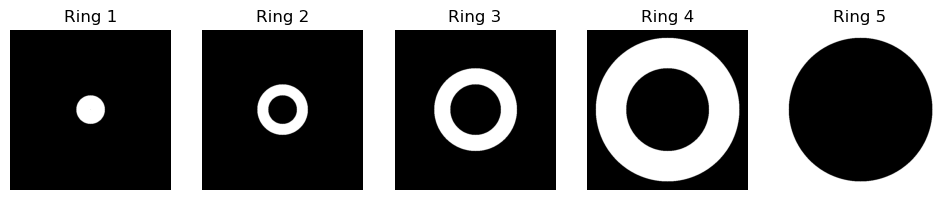

In [5]:
image = cv2.imread(nickels_cropped_files[0])
num_rings = 5
ring_masks = create_ring_masks_const(image, num_rings)

plt.figure(figsize = (12, 4))

for i, mask in enumerate(ring_masks, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

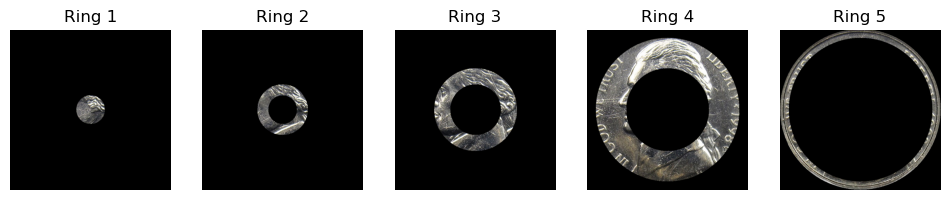

In [6]:
cropped_imgs = []
for mask in ring_masks:
    cropped = cv2.bitwise_and(image, image, mask = mask[:, :, 0])
    cropped_imgs.append(cropped)

plt.figure(figsize = (12, 4))

for i, cropped in enumerate(cropped_imgs, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

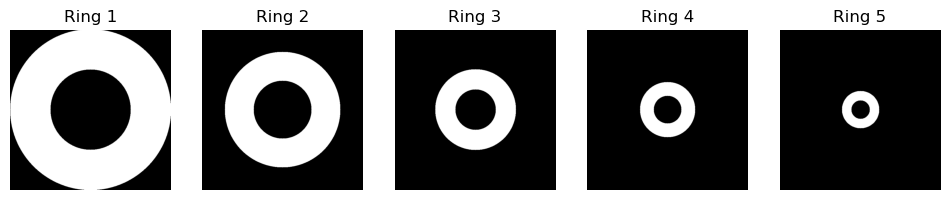

In [7]:
image = cv2.imread(nickels_cropped_files[0])
num_rings = 5
ring_masks = create_ring_masks_with_growth_factor(image, num_rings, growth_rate = 0.6)

plt.figure(figsize = (12, 4))
for i, mask in enumerate(ring_masks, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

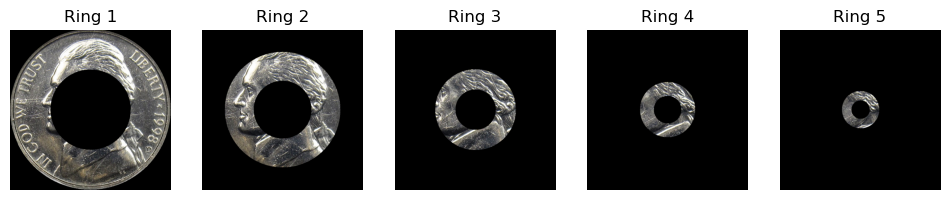

In [8]:
cropped_imgs = []
for mask in ring_masks:
    cropped = cv2.bitwise_and(image, image, mask = mask[:, :, 0])
    cropped_imgs.append(cropped)

plt.figure(figsize = (12, 4))

for i, cropped in enumerate(cropped_imgs, 1):
    plt.subplot(1, num_rings, i)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f'Ring {i}')
    plt.axis('off')

plt.show()

In [10]:
ring_masks[1][:, :, 0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
def apply_adaptive_histogram_equalization(image, clip_limit = 1.5, tile_size = (8, 8)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_image, (15, 15), 0)

    clahe = cv2.createCLAHE(clipLimit = clip_limit, 
                            tileGridSize = tile_size)
    equalized_image = clahe.apply(blur_img)
    
    return equalized_image

In [10]:
def calculate_gradient(image, kernel_size = 3):
    equalized_img = apply_adaptive_histogram_equalization(image, tile_size = (3, 3))
    # Compute gradient using Sobel operators
    gradient_x = cv2.Sobel(equalized_img, cv2.CV_64F, 1, 0, ksize = kernel_size)
    gradient_y = cv2.Sobel(equalized_img, cv2.CV_64F, 0, 1, ksize = kernel_size)

    # Compute gradient magnitude and orientation
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_orientation

In [11]:
coin_features_df = pd.DataFrame({
    "img": [],
    "img_type": [],

    "magnitude_mean": [],
    "magnitude_median": [],

    "h_mean": [],
    "h_std": [],
    "h_skewness": [],
    "h_kurtosis": [],
    "s_mean": [],
    "s_std": [],
    "s_skewness": [],
    "s_kurtosis": [],
    "v_mean": [],
    "v_std": [],
    "v_skewness": [],
    "v_kurtosis": [],

    "ring_1_magnitude_mean": [],
    "ring_1_magnitude_median": [],
    "ring_1_orientation_mean": [],
    "ring_1_orientation_median": [],
    "ring_1_h_mean": [],
    "ring_1_h_std": [],
    "ring_1_h_skewness": [],
    "ring_1_h_kurtosis": [],
    "ring_1_s_mean": [],
    "ring_1_s_std": [],
    "ring_1_s_skewness": [],
    "ring_1_s_kurtosis": [],
    "ring_1_v_mean": [],
    "ring_1_v_std": [],
    "ring_1_v_skewness": [],
    "ring_1_v_kurtosis": [],

    "ring_2_magnitude_mean": [],
    "ring_2_magnitude_median": [],
    "ring_2_orientation_mean": [],
    "ring_2_orientation_median": [],
    "ring_2_h_mean": [],
    "ring_2_h_std": [],
    "ring_2_h_skewness": [],
    "ring_2_h_kurtosis": [],
    "ring_2_s_mean": [],
    "ring_2_s_std": [],
    "ring_2_s_skewness": [],
    "ring_2_s_kurtosis": [],
    "ring_2_v_mean": [],
    "ring_2_v_std": [],
    "ring_2_v_skewness": [],
    "ring_2_v_kurtosis": [],

    "ring_3_magnitude_mean": [],
    "ring_3_magnitude_median": [],
    "ring_3_orientation_mean": [],
    "ring_3_orientation_median": [],
    "ring_3_h_mean": [],
    "ring_3_h_std": [],
    "ring_3_h_skewness": [],
    "ring_3_h_kurtosis": [],
    "ring_3_s_mean": [],
    "ring_3_s_std": [],
    "ring_3_s_skewness": [],
    "ring_3_s_kurtosis": [],
    "ring_3_v_mean": [],
    "ring_3_v_std": [],
    "ring_3_v_skewness": [],
    "ring_3_v_kurtosis": [],

    "ring_4_magnitude_mean": [],
    "ring_4_magnitude_median": [],
    "ring_4_orientation_mean": [],
    "ring_4_orientation_median": [],
    "ring_4_h_mean": [],
    "ring_4_h_std": [],
    "ring_4_h_skewness": [],
    "ring_4_h_kurtosis": [],
    "ring_4_s_mean": [],
    "ring_4_s_std": [],
    "ring_4_s_skewness": [],
    "ring_4_s_kurtosis": [],
    "ring_4_v_mean": [],
    "ring_4_v_std": [],
    "ring_4_v_skewness": [],
    "ring_4_v_kurtosis": [],

    "ring_5_magnitude_mean": [],
    "ring_5_magnitude_median": [],
    "ring_5_orientation_mean": [],
    "ring_5_orientation_median": [],
    "ring_5_h_mean": [],
    "ring_5_h_std": [],
    "ring_5_h_skewness": [],
    "ring_5_h_kurtosis": [],
    "ring_5_s_mean": [],
    "ring_5_s_std": [],
    "ring_5_s_skewness": [],
    "ring_5_s_kurtosis": [],
    "ring_5_v_mean": [],
    "ring_5_v_std": [],
    "ring_5_v_skewness": [],
    "ring_5_v_kurtosis": [],
})

In [12]:
def extract_shape_features(image_file, ind):
    image = cv2.imread(image_file)
    gradient_magnitude, gradient_orientation = calculate_gradient(image, kernel_size=3)
    color_features = extract_color_features(image)
    ring_masks = create_ring_masks_with_growth_factor(image, num_rings, growth_rate = 0.8, inner_outer_ratio = 0.5)

    # Update scalar (single-valued) features
    coin_features_df.loc[ind, 'img'] = image_file

    coin_features_df.loc[ind, 'magnitude_mean'] = np.mean(gradient_magnitude)
    coin_features_df.loc[ind, 'magnitude_median'] = np.median(gradient_magnitude)
    coin_features_df.loc[ind, 'orientation_mean'] = np.mean(gradient_orientation)
    coin_features_df.loc[ind, 'orientation_median'] = np.median(gradient_orientation)

    coin_features_df.loc[ind, 'h_mean'] = color_features[0]
    coin_features_df.loc[ind, 'h_std'] = color_features[1]
    coin_features_df.loc[ind, 'h_skewness'] = color_features[2]
    coin_features_df.loc[ind, 'h_kurtosis'] = color_features[3]

    coin_features_df.loc[ind, 's_mean'] = color_features[4]
    coin_features_df.loc[ind, 's_std'] = color_features[5]
    coin_features_df.loc[ind, 's_skewness'] = color_features[6]
    coin_features_df.loc[ind, 's_kurtosis'] = color_features[7]

    coin_features_df.loc[ind, 'v_mean'] = color_features[8]
    coin_features_df.loc[ind, 'v_std'] = color_features[9]
    coin_features_df.loc[ind, 'v_skewness'] = color_features[10]
    coin_features_df.loc[ind, 'v_kurtosis'] = color_features[11]
    
    for i, ring_mask in enumerate(ring_masks):
        cropped = cv2.bitwise_and(image, image, mask = ring_mask[:, :, 0])
        ring_gradient_magnitude, ring_gradient_orientation = calculate_gradient(cropped, kernel_size=3)
        ring_color_features = extract_color_features(cropped)

        ring_label = f'ring_{i + 1}'
        coin_features_df.loc[ind, f'{ring_label}_magnitude_mean'] = np.mean(ring_gradient_magnitude)
        coin_features_df.loc[ind, f'{ring_label}_magnitude_median'] = np.median(ring_gradient_magnitude)
        coin_features_df.loc[ind, f'{ring_label}_orientation_mean'] = np.mean(ring_gradient_orientation)
        coin_features_df.loc[ind, f'{ring_label}_orientation_median'] = np.median(ring_gradient_orientation)

        coin_features_df.loc[ind, f'{ring_label}_h_mean'] = ring_color_features[0]
        coin_features_df.loc[ind, f'{ring_label}_h_std'] = ring_color_features[1]
        coin_features_df.loc[ind, f'{ring_label}_h_skewness'] = ring_color_features[2]
        coin_features_df.loc[ind, f'{ring_label}_h_kurtosis'] = ring_color_features[3]
        
        coin_features_df.loc[ind, f'{ring_label}_s_mean'] = ring_color_features[4]
        coin_features_df.loc[ind, f'{ring_label}_s_std'] = ring_color_features[5]
        coin_features_df.loc[ind, f'{ring_label}_s_skewness'] = ring_color_features[6] 
        coin_features_df.loc[ind, f'{ring_label}_s_kurtosis'] = ring_color_features[7]
        
        coin_features_df.loc[ind, f'{ring_label}_v_mean'] = ring_color_features[8]
        coin_features_df.loc[ind, f'{ring_label}_v_std'] = ring_color_features[9]
        coin_features_df.loc[ind, f'{ring_label}_v_skewness'] = ring_color_features[10]
        coin_features_df.loc[ind, f'{ring_label}_v_kurtosis'] = ring_color_features[11]

In [13]:
directories = [nickels_cropped_dir, quarters_cropped_dir, cents_cropped_dir]
all_imgs_len = len(nickels_cropped_files) + len(quarters_cropped_files) + len(cents_cropped_files)
ind = 0

for directory in directories:
    if "nickels" in directory:
        img_type = "Nickels"
    elif "quarters" in directory:
        img_type = "Quarters"
    elif "cents" in directory:
        img_type = "Cents"

    cropped_files = glob(f"{directory}/*")
    for file in tqdm(cropped_files, desc = f"Processing {img_type}"):
        img = cv2.imread(file)

        extract_shape_features(file, ind)
        coin_features_df.loc[ind, 'img_type'] = img_type

        ind+= 1

Processing Nickels:   0%|          | 0/1133 [00:00<?, ?it/s]

Processing Cents: 100%|██████████| 1161/1161 [07:41<00:00,  2.52it/s]


In [14]:
coin_features_df.to_parquet('./processed_dfs/coin_features_df_extract_features_7_1.parquet')